![Задача №2](2.png)

In [2]:
# Данные
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

Y = list(map(float, "13.17, 11.78, 11.70, 12.54, 11.59, 11.21, 9.57, 9.07, 10.10, 10.60, 9.22, 7.91, 17.17, 14.74, 16.37, 15.34, 16.72, 16.53, 11.08, 12.01, 12.62, 11.07, 11.36, 11.78, 14.85, 14.60, 15.40, 13.23, 15.32, 13.23, 21.08, 20.70, 23.04, 21.22, 23.35, 22.51, 20.08, 18.89, 21.47, 19.55, 20.88, 20.01, 17.06, 18.76, 18.05, 17.83, 17.33, 18.30".split(", ")))
A = [1]*24 + [2]*24
B = [1]*6 + [2]*6 + [3]*6 + [4]*6 + [1]*6 + [2]*6 + [3]*6 + [4]*6

df = pd.DataFrame({"Y": Y, "A": A, "B": B})

Y = df["Y"]
A = df["A"]
B = df["B"]
alpha = 0.02
h = 0.82

df.head()


Y  A  B
0  13.17  1  1
1  11.78  1  1
2  11.70  1  1
3  12.54  1  1
4  11.59  1  1

## Пункт а)
### 1. Формулировка модели двухфакторного дисперсионного анализа
Модель с взаимодействием факторов:
$$
Y_{ijk} = \mu + \alpha_i + \beta_j + (\alpha \beta)_{ij} + \epsilon_{ijk},
$$
где:
- $Y_{ijk}$ — наблюдаемое значение переменной $Y$ для $i$-го уровня фактора $A$, $j$-го уровня фактора $B$, $k$-го повторения,
- $\mu$ — общее среднее,
- $\alpha_i$ — эффект $i$-го уровня фактора $A$,
- $\beta_j$ — эффект $j$-го уровня фактора $B$,
- $(\alpha \beta)_{ij}$ — эффект взаимодействия факторов $A$ и $B$,
- $\epsilon_{ijk} \sim N(0, \sigma^2)$ — случайная ошибка.

### 2. Построение МНК-оценок параметров

In [3]:
from statsmodels.formula.api import ols

# Формируем модель с взаимодействием
model_full = ols('Y ~ C(A) + C(B) + C(A):C(B)', data=df).fit()

# МНК-оценки параметров
params = model_full.params
print("Оценки параметров полной модели:")
print(params)

Оценки параметров полной модели:
Intercept              11.998333
C(A)[T.2]               2.440000
C(B)[T.2]              -2.586667
C(B)[T.3]               4.146667
C(B)[T.4]              -0.345000
C(A)[T.2]:C(B)[T.2]    10.131667
C(A)[T.2]:C(B)[T.3]     1.561667
C(A)[T.2]:C(B)[T.4]     3.795000
dtype: float64


### 3. Несмещенная оценка дисперсии
Несмещенная оценка дисперсии ошибок:
$$
\hat{\sigma}^2 = \frac{SS_{\text{res}}}{df_{\text{res}}},
$$
где:
- $SS_{\text{res}}$ — сумма квадратов остатков,
- $df_{\text{res}} = n - p$ — степени свободы ($n$ — число наблюдений, $p$ — число параметров).

In [4]:
# Несмещенная оценка дисперсии
sigma2 = model_full.mse_resid
print(f"Несмещенная оценка дисперсии: {sigma2:.3f}")

Несмещенная оценка дисперсии: 0.757


## Пункт b)

In [5]:
# Группируем данные по комбинациям A и B, вычисляем средние Y
grouped = df.groupby(['A', 'B'])['Y'].mean().reset_index()

# Создаём сводную таблицу для визуализации
pivot_table = grouped.pivot(index='A', columns='B', values='Y')
print("Сводная таблица средних значений Y:")
print(pivot_table)

Сводная таблица средних значений Y:
B          1          2          3          4
A                                            
1  11.998333   9.411667  16.145000  11.653333
2  14.438333  21.983333  20.146667  17.888333


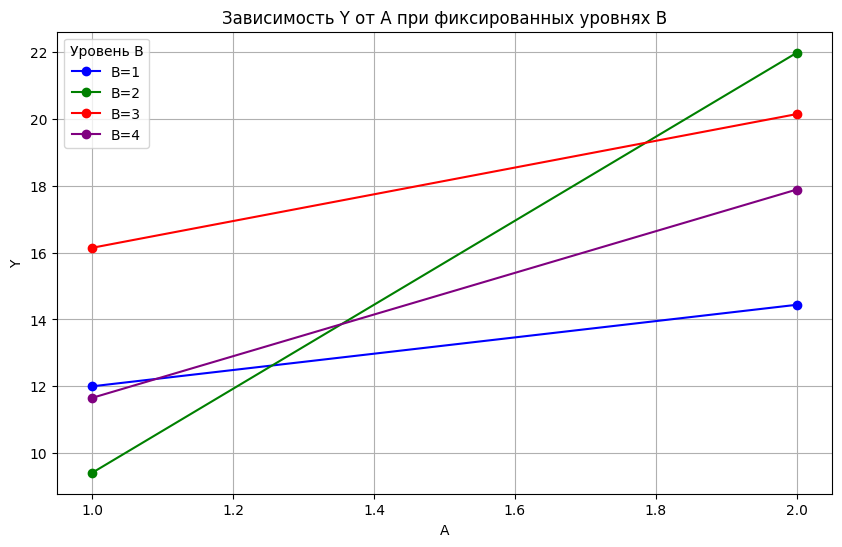

In [6]:
plt.figure(figsize=(10, 6))

# Уровни фактора B
B_levels = df['B'].unique()

# Цвета для каждого уровня B
colors = ['blue', 'green', 'red', 'purple']

for b, color in zip(B_levels, colors):
    # Фильтруем данные для текущего уровня B
    subset = grouped[grouped['B'] == b]
    plt.plot(subset['A'], subset['Y'], 
             marker='o', 
             linestyle='-', 
             color=color, 
             label=f'B={b}')

plt.xlabel('A')
plt.ylabel('Y')
plt.title('Зависимость Y от A при фиксированных уровнях B')
plt.legend(title='Уровень B')
plt.grid(True)
plt.show()

### Визуальная проверка аддитивности:

- **Пересечение линий:** График зависимости $Y$ от $A$ при фиксированных $B$ показывает, что линии для разных уровней $B$ пересекаются, особенно при $B=4$. Это указывает на **наличие взаимодействия** между факторами.
- **Следствия:** Взаимодействие факторов может означать, что влияние одного фактора на зависимую переменную $Y$ зависит от другого фактора.


## Пункт c)

In [7]:
from statsmodels.formula.api import ols

# Аддитивная модель
model_additive = ols('Y ~ C(A) + C(B)', data=df).fit()

# Остатки модели
residuals = model_additive.resid

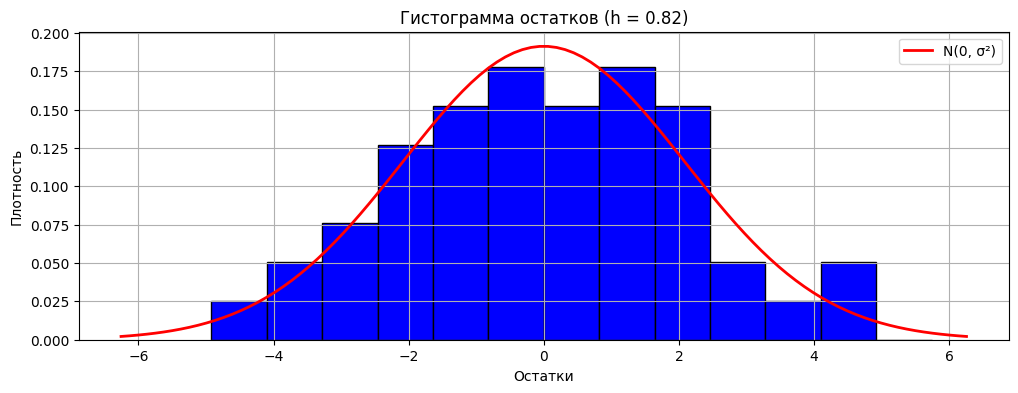

In [8]:
# Определение границ бинов
min_res = np.floor(residuals.min() / h) * h
max_res = np.ceil(residuals.max() / h) * h
bin_edges = np.arange(min_res, max_res + h, h)

# Гистограмма
plt.figure(figsize=(12, 4))
plt.hist(residuals, bins=bin_edges, density=True, color='blue', edgecolor='black')
plt.xlabel('Остатки')
plt.ylabel('Плотность')
plt.title('Гистограмма остатков (h = 0.82)')
plt.grid(True)

# Наложение нормального распределения
mu = 0  # Остатки центрированы вокруг 0
sigma = np.std(residuals)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2)), 
         color='red', linewidth=2, label='N(0, σ²)')
plt.legend()
plt.show()

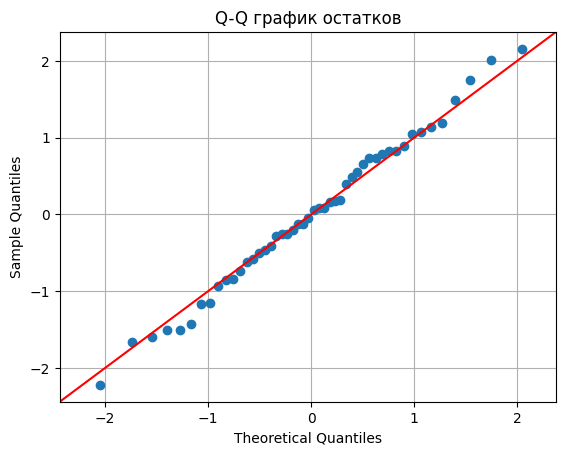

In [9]:
import statsmodels.api as sm

sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q график остатков')
plt.grid(True)
plt.show()

In [10]:
from scipy.stats import shapiro

stat, p_value = shapiro(residuals)
print(f"Тест Шапиро-Уилка: p-value = {p_value:.3f}")
if p_value < 0.02:
    print("Отвергаем H₀: остатки не нормальны.")
else:
    print("Не отвергаем H₀: остатки нормальны.")

Тест Шапиро-Уилка: p-value = 0.949
Не отвергаем H₀: остатки нормальны.


### Результаты
- **Гистограмма:** Распределение остатков близко к нормальному, совпадает с наложенной кривой $N(0, \sigma^2)$.
- **Q-Q график:** Точки лежат вдоль линии $y=x$, что подтверждает нормальность.
- **Тест Шапиро-Уилка:** гипотеза о нормальности не отвергается.

## Пункт d)

In [12]:
from statsmodels.stats.anova import anova_lm
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Предположим, df - ваш DataFrame с колонками 'Y', 'A', 'B'
# где A и B - категориальные факторы

# 1. Построение моделей
model_full = ols('Y ~ C(A) + C(B) + C(A):C(B)', data=df).fit()
model_additive = ols('Y ~ C(A) + C(B)', data=df).fit()
model_onlyA = ols('Y ~ C(A)', data=df).fit()
model_onlyB = ols('Y ~ C(B)', data=df).fit()
model_const = ols('Y ~ 1', data=df).fit()


Таблица ANOVA для полной модели:
             df      sum_sq     mean_sq           F        PR(>F)
C(A)        1.0  478.108752  478.108752  631.694471  4.061068e-26
C(B)        3.0  153.241356   51.080452   67.489330  1.051893e-15
C(A):C(B)   3.0  178.558140   59.519380   78.639144  8.022881e-17
Residual   40.0   30.274683    0.756867         NaN           NaN

Отсортированная таблица дисперсионного анализа:
             df      sum_sq     mean_sq           F        PR(>F)
C(A)        1.0  478.108752  478.108752  631.694471  4.061068e-26
C(A):C(B)   3.0  178.558140   59.519380   78.639144  8.022881e-17
C(B)        3.0  153.241356   51.080452   67.489330  1.051893e-15
Residual   40.0   30.274683    0.756867         NaN           NaN


In [21]:

from scipy.stats import f

# Функция для сравнения моделей и извлечения нужных данных
def compare_models(reduced_model, full_model):
    anova_result = sm.stats.anova_lm(reduced_model, full_model)
    return {
        'df_diff': anova_result['df_diff'].iloc[1],  # Разница степеней свободы
        'ss_diff': anova_result['ss_diff'].iloc[1],  # Разница в RSS
        'rss_reduced': reduced_model.ssr,  # RSS редуцированной модели
        'rss_full': full_model.ssr,       # RSS полной модели
        'F': anova_result['F'].iloc[1],   # F-статистика
        'p_value': anova_result['Pr(>F)'].iloc[1]  # P-значение
    }

# Сравнение моделей
anova_additive = compare_models(model_additive, model_full)
anova_A = compare_models(model_onlyA, model_full)
anova_B = compare_models(model_onlyB, model_full)
anova_null = compare_models(model_const, model_full)

# Создание DataFrame для результатов
columns = ['H', 'RSS', 'Df', 'Sum of Sq', 'F', 'x_alpha', 'Pr(>F)']
AOV = pd.DataFrame(columns=columns)

# Функция для добавления строк в AOV
def add_aov_row(df, name, anova_result, rdf, alpha):
    row = {
        'H': name,
        'RSS': anova_result['rss_reduced'],  # Теперь берём RSS редуцированной модели
        'Df': anova_result['df_diff'],
        'Sum of Sq': anova_result['ss_diff'],
        'F': anova_result['F'],
        'x_alpha': f.ppf(1 - alpha, anova_result['df_diff'], rdf),
        'Pr(>F)': f"{anova_result['p_value']:.7g}", 
    }
    return pd.concat([df, pd.DataFrame([row])], ignore_index=True)

# Получение residual degrees of freedom из полной модели
rdf = model_full.df_resid

# Добавление строк в AOV
AOV = add_aov_row(AOV, 'H_(12)', anova_additive, rdf, alpha)
AOV = add_aov_row(AOV, 'H_(1)', anova_A, rdf, alpha)
AOV = add_aov_row(AOV, 'H_(2)', anova_B, rdf, alpha)
AOV = add_aov_row(AOV, 'H_(0)', anova_null, rdf, alpha)

# Добавление строки ошибок (RSS полной модели)
error_row = {
    'H': 'Err',
    'RSS': model_full.ssr,
    'Df': rdf,
    'Sum of Sq': None,
    'F': None,
    'x_alpha': None,
    'Pr(>F)': None
}
AOV = pd.concat([AOV, pd.DataFrame([error_row])], ignore_index=True)

# Вычисление MRSS (Mean Residual Sum of Squares)
AOV['MRSS'] = AOV['RSS'] / AOV['Df']

# Финальная обработка AOV (перестановка столбцов)
AOV1 = AOV[['H', 'RSS', 'Df', 'MRSS', 'F', 'x_alpha', 'Pr(>F)']]

# Вывод результатов
AOV1


C:\Users\margaery\AppData\Local\Temp\ipykernel_18780\711296804.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df, pd.DataFrame([row])], ignore_index=True)
C:\Users\margaery\AppData\Local\Temp\ipykernel_18780\711296804.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  AOV = pd.concat([AOV, pd.DataFrame([error_row])], ignore_index=True)


H         RSS    Df        MRSS           F   x_alpha        Pr(>F)
0  H_(12)  208.832823   3.0   69.610941   78.639144  3.667421  8.022881e-17
1   H_(1)  362.074179   6.0   60.345697   73.064237  2.876587  5.459874e-20
2   H_(2)  686.941575   4.0  171.735394  216.902976  3.295372  1.537422e-26
3   H_(0)  840.182931   7.0  120.026133  152.868556  2.744837  8.275092e-27
4     Err   30.274683  40.0    0.756867         NaN       NaN          None

### Результаты ANOVA
Из таблицы ANOVA:
- **Фактор A:**
  $$
  F = 631.69,\ p\text{-value} < 0.001 \ \rightarrow \ \text{значимо влияет на } Y.
  $$
  
- **Фактор B:**
  $$
  F = 67.49,\ p\text{-value} < 0.001 \ \rightarrow \ \text{значимо влияет на } Y.
  $$
  
- **Взаимодействие $A \times B$:**
  $$
  F = 78.64,\ p\text{-value} < 0.001 \ \rightarrow \ \text{значимо влияет на } Y.
  $$

- **Вывод:**
  На уровне значимости $\alpha=0.02$ все факторы (A, B) и их взаимодействие **значимо**. Это означает, что влияние фактора A на Y зависит от уровня фактора B, и наоборот.

## Пункт e)
Для выбора оптимальной модели используются критерии:
- AIC оценивает баланс между качеством подгонки модели и её сложностью, накладывая штраф за избыточное количество параметров.
- BIC работает аналогично AIC, но применяет более строгий штраф за сложность, особенно при больших объемах данных.

Сравниваем модели:
1. **Полная модель** (с взаимодействием): 
   $$
   Y \sim A + B + AB.
   $$
2. **Аддитивная модель** (без взаимодействия):
   $$
   Y \sim A + B.
   $$
3. **Только А**:
   $$
   Y \sim A
   $$
4. **Только В**:
   $$
   Y \sim B
   $$
5. **Константная**:
   $$
   Y \sim 1
   $$

In [12]:

# 3. Таблица AIC/BIC для всех моделей (как во втором изображении)
models = {
    'Полная': model_full,
    'Аддитивная': model_additive,
    'Только A': model_onlyA,
    'Только B': model_onlyB,
    'Константная': model_const
}

results = []
for name, model in models.items():
    results.append({
        'Модель': name,
        'AIC': model.aic,
        'BIC': model.bic
    })

aic_bic_table = pd.DataFrame(results)
print("\nСравнение моделей по AIC и BIC:")
print(aic_bic_table)


Сравнение моделей по AIC и BIC:
        Модель         AIC         BIC
0       Полная  130.095418  145.065027
1   Аддитивная  216.794085  226.150090
2     Только A  237.209208  240.951610
3     Только B  271.948414  279.433218
4  Константная  275.614194  277.485395


### Вывод о сравнении моделей

- **Результаты AIC и BIC:**
  - **AIC:** Минимален у полной модели (не меньше чем на 86.7 меньше, чем у остальных).
  - **BIC:** Минимален у полной модели (не меньше чем на 81.08 меньше, чем у остальных).

- **Заключение:**
  - Полная модель **предпочтительнее**, так как она лучше соответствует данным, что подтверждается меньшими значениями AIC и BIC.